In [1]:
cd ..

/Users/dorislee/Desktop/Research/covid/covid19-vis


In [2]:
import pandas as pd
import numpy as np
from chartlib.utils import create_lockdown_type, split_into_list, str2emo
df = pd.read_csv("data/quarantine-activity-US-Apr16-long.csv")

In [3]:
# START modified from _ingest_usa_quarantine_df
quarantine_csv = "data/quarantine-activity-US-Apr16-long.csv"
quarantine_df = pd.read_csv(quarantine_csv)
groupcol = 'Province_State'

quarantine_df = quarantine_df.rename(columns={'State': 'Province_State', 'Effective Date': 'lockdown_date','Coverage.type':'Coverage'})
quarantine_df = quarantine_df.sort_values('Coverage', ascending=True)
quarantine_df['lockdown_type'] = quarantine_df.apply(lambda x: create_lockdown_type(x, 0), axis=1)
quarantine_df['emoji_string'] = quarantine_df.apply(lambda x: create_lockdown_type(x, 1), axis=1)
quarantine_df['lockdown_type'].replace('', np.nan, inplace=True)

quarantine_df = quarantine_df.dropna(subset=['lockdown_type'])
# #TODO: this is where the columns get dropped
# quarantine_df = quarantine_df.groupby(['lockdown_date', 'Province_State']).agg({
#     'lockdown_type': lambda col: '; '.join(col),
#     'emoji_string': lambda col: ''.join(col),
#     'population_size': lambda col:col,
#     'Coverage.location': lambda col:col
# }).reset_index()

quarantine_df.loc[quarantine_df.lockdown_type=="Regional Border Closure/Visitor Quarantine","emoji_string"]="t"#bugfix
# Breaking up emoji into separate rows for vertical stacking
quarantine_df.emoji_string = quarantine_df.emoji_string.apply(split_into_list)

quarantine_df = quarantine_df.explode(column='emoji_string')
quarantine_df['Coverage'] = quarantine_df.emoji_string.apply(
    lambda x: 'Statewide' if str(x).isupper() else 'Regional'
)
quarantine_df = quarantine_df.sort_values('Coverage', ascending=False)
quarantine_df.emoji_string = quarantine_df.emoji_string.str.lower()
quarantine_df['emoji'] = quarantine_df['emoji_string'].map(str2emo)
quarantine_df['event_index'] = quarantine_df.groupby(['Province_State', 'lockdown_date']).cumcount()

# # quarantine_cols = [
# #     groupcol, 'lockdown_date', 'lockdown_type', 'emoji', 'emoji_string', 'event_index', 'Coverage','Coverage.location'
# # ]
quarantine_cols = ['Province_State', 'Coverage', 'Coverage.location', 'lockdown_date','population_size','lockdown_type', 'emoji_string', 'emoji',
       'event_index']
quarantine_df = quarantine_df[quarantine_cols]

# # END modified from _ingest_usa_quarantine_df

In [4]:
quarantine_df[quarantine_df.emoji_string=="c"]

,Province_State,Coverage,Coverage.location,lockdown_date,population_size,lockdown_type,emoji_string,emoji,event_index
196,Kentucky,Statewide,Kentucky,2020-04-01,4467673,Border Closure/Visitor Quarantine,c,🛩,0
153,Hawaii,Regional,Kauai,2020-03-20,72293,"Regional Border Closure/Visitor Quarantine, Cu...",c,🛩,1


In [5]:
quarantine_df_orig = pd.read_csv(quarantine_csv)
state_populations = quarantine_df_orig[quarantine_df_orig["Coverage.type"]=="State-wide"][["State","population_size"]].drop_duplicates()
state_populations = state_populations.rename(columns={'State': 'Province_State',"population_size":"state_population_size"})
state_populations.loc[state_populations["Province_State"]=="Puerto Rico","state_population_size"] = 3725789 # Obtained from https://www.census.gov/quickfacts/PR
state_populations.state_population_size = state_populations.state_population_size.astype("int")

In [6]:
quarantine_df = quarantine_df.merge(state_populations)

In [7]:
# 'e':Declaration of Emergency 
# 't':'Travel restrictions'
# 'c': Border Closure/Visitor Quarantine
# 's': School closure 
# 'n':Closure of non-essential businesses
# 'l': Stay at home order
severityScore = {'e':0.1,'g':0.3, 'c':0.3, 's':0.4,'r':0.6 , 't':0.6, 'n':0.8, 'l':1}

In [8]:
# quarantine_df[quarantine_df["population_size"].isna()]
quarantine_df = quarantine_df.dropna(subset=["population_size"])
quarantine_df.population_size = quarantine_df.population_size.str.replace(",","")
quarantine_df.population_size = quarantine_df.population_size.astype("int")

In [9]:
quarantine_df["severityScore"] = quarantine_df.emoji_string.apply(lambda x: severityScore[x])

In [10]:
quarantine_df.lockdown_date = quarantine_df.lockdown_date.str.replace("/","-")

In [11]:
quarantine_df.lockdown_date = pd.to_datetime(quarantine_df.lockdown_date)

In [12]:
quarantine_df = quarantine_df[['Province_State', 'Coverage', 'Coverage.location', 'lockdown_date',
       'population_size', 'state_population_size', 'severityScore']]

In [13]:
qdf = quarantine_df[quarantine_df["Province_State"]=="Missouri"]

In [14]:
def compute_state_replacements(qdf,state):
    df_state_replacements = []
    qdf = quarantine_df[quarantine_df["Province_State"]==state]
    statewideEvents = qdf[qdf["Coverage"]=="Statewide"]
    relevantCountiesInState= list(set(qdf[qdf["Province_State"]==state]["Coverage.location"]) - set([state]))
    # adding "Others" dummy state populated with statewide population - sum(relevant counties population)
    relevantCountiesInState= list(set(qdf[qdf["Province_State"]==state]["Coverage.location"]) - set([state]))
    relevant_county_population_lookup = qdf[qdf["Coverage.location"].isin(relevantCountiesInState)][["Coverage.location","population_size"]].drop_duplicates()
    state_population_size = state_populations[state_populations["Province_State"]==state].state_population_size.values[0]
    other_population = state_population_size - relevant_county_population_lookup.population_size.sum()
    qdf.loc[len(qdf)] = [state,"Regional","Others",np.nan,other_population,state_population_size,np.nan]
    relevantCountiesInState  = relevantCountiesInState + ["Others"]
    for statewideEvent in statewideEvents.iterrows(): 
    #     statewideLockdown_date = "2020-03-12"
    #     statewideSeverity = "0.1"
        statewideLockdown_date = statewideEvent[1].lockdown_date
        statewideSeverity = statewideEvent[1].severityScore
        for county in relevantCountiesInState: 
            #print(county)
            #display(qdf[qdf["Coverage.location"]==county])
            try:
                # Catch error since some counties don't show up until a later date, ignore these counties 
                clone = np.repeat(qdf[qdf["Coverage.location"]==county].iloc[0],1)
                clone.lockdown_date = statewideLockdown_date
                clone.severityScore = statewideSeverity
                df_state_replacements.append(clone)
            except (IndexError):
                pass
                

    df_state_replacements = pd.DataFrame(df_state_replacements,columns=qdf.columns)
    return df_state_replacements 

In [15]:
def compute_state_intervention_footprint_curve(state):
    qdf = quarantine_df[quarantine_df["Province_State"]==state]
    qdf_additional = compute_state_replacements(qdf,state)
    qdf_result = pd.concat([qdf,qdf_additional])
    # For each date, compute a cumulative max, keeping only the entry with the maximum severity score
    qdf_keep_all=[]
    for ldate in qdf.lockdown_date.unique():
        # ldate = "2020-03-13"
        qdf_before = qdf_result[qdf_result["lockdown_date"]<=ldate]
        # Compute the max severity for that location for the given day
        qdf_before["severityMax"] = qdf_before.groupby("Coverage.location")["severityScore"].transform(max)
        qdf_keep = qdf_before[qdf_before["severityScore"] == qdf_before["severityMax"]]
        qdf_keep["dateBefore"] = ldate
        qdf_keep = qdf_keep.drop_duplicates(subset="Coverage.location") # applicable only for the last date when severityMax=1 for multiple lockdown_dates, keep just one so that last entry doesn't exceed 1
        qdf_keep_all.append(qdf_keep)
    #     display(qdf_keep)
    qdf_keep_all = pd.concat(qdf_keep_all)

    # compute the intervention footprint for the kept df
    qdf_keep_all["pctStateAffected"]= qdf_keep_all["population_size"]/qdf_keep_all["state_population_size"]
    qdf_keep_all["interventionFootprint"] = qdf_keep_all["pctStateAffected"]*qdf_keep_all["severityScore"]

    qdf_keep_all = qdf_keep_all[qdf_keep_all["Coverage"]=="Regional"]
    # Sum the intervention footprint based on the date we used for the keep max (note this is based on the lockdown date)
    qdf_keep_all_result = qdf_keep_all.groupby("dateBefore").sum().reset_index()
    return qdf_keep_all_result

In [16]:
statedf = compute_state_intervention_footprint_curve("Missouri")

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [17]:
df_all = []
for state in quarantine_df.Province_State.unique():
    print (state)
    
    statedf = compute_state_intervention_footprint_curve(state)
    statedf["State"]=state
    df_all.append(statedf)

df_all = pd.concat(df_all)

Alabama
Virginia
Arkansas
Missouri


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

California
South Carolina
Mississippi
West Virginia
Washington
Wyoming
Wisconsin
Utah
Arizona
Oklahoma
Ohio
Vermont
Massachusetts
Nebraska
Minnesota
Michigan
South Dakota
Tennessee
Colorado
Montana
Alaska
North Carolina
Texas
North Dakota
Maryland
Kansas
Maine
Florida
Nevada
Connecticut
Rhode Island
Georgia
New York
Pennsylvania
Louisiana
Kentucky
Oregon
New Hampshire
Idaho
New Mexico
New Jersey
Delaware
Illinois
Indiana
Hawaii
Iowa


In [18]:
df_all.to_csv("interventionFootprintByState.csv")

In [19]:
# df_all.dateBefore.min()
# df_all.dateBefore.max()

In [20]:
import altair as alt 
domain_pd = pd.to_datetime(['2020-03-01', '2020-04-01']).astype(int) / 10 ** 6
chart = alt.Chart(df_all).mark_line().encode(
        x = alt.X("dateBefore", scale=alt.Scale(domain=list(domain_pd))),
        y = alt.Y("interventionFootprint", scale=alt.Scale(0,1)),
        facet=alt.Facet('State:O', columns=4),
    )
chart.properties(width=150,height=100).interactive()

alt.Chart(...)

# Clustering time series

In [21]:
df_all

,dateBefore,population_size,state_population_size,severityScore,severityMax,pctStateAffected,interventionFootprint,State
0,2020-03-13,4903185,19612740,0.4,0.4,1.0,0.100000,Alabama
1,2020-03-18,4903185,19612740,1.6,1.6,1.0,0.400000,Alabama
2,2020-03-24,4903185,19612740,2.2,2.2,1.0,0.425683,Alabama
3,2020-03-27,4903185,19612740,3.8,3.8,1.0,0.820771,Alabama
4,2020-04-04,4903185,19612740,4.0,4.0,1.0,1.000000,Alabama
...,...,...,...,...,...,...,...,...
4,2020-03-21,1415872,5663488,2.8,2.8,1.0,0.620424,Hawaii
5,2020-03-22,1415872,5663488,3.2,3.2,1.0,0.895749,Hawaii
6,2020-03-25,1415872,5663488,4.0,4.0,1.0,1.000000,Hawaii
0,2020-03-09,3155070,3155070,0.1,0.1,1.0,0.100000,Iowa


In [22]:
tseries = df_all.pivot(index="State",columns='dateBefore',values="interventionFootprint")

In [23]:
tseries[tseries.columns.min()] = tseries[tseries.columns.min()].fillna(0)

In [24]:
tseries = tseries.interpolate('linear',axis=1)

In [25]:
# tseries.index= ["State","dateBefore"]

In [26]:
tseries4plot = tseries.transpose().melt()

In [27]:
len(tseries4plot)

2000

In [28]:
series = []
for state in tseries4plot.State.unique():
    series.extend(range(40))

In [29]:
index = pd.Series(series)

In [30]:
tseries4plot["index"]=index

In [31]:
chart = alt.Chart(tseries4plot).mark_line().encode(
        x = alt.X("index"),
        y = alt.Y("value", scale=alt.Scale(0,1)),
        facet=alt.Facet('State:O', columns=4),
    )
chart.properties(width=150,height=100,title="Smoothed Curve").interactive()

alt.Chart(...)

In [32]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = 4
clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(tseries.values)
labels = pd.Series(clustering.labels_,name="Cluster")
labels.value_counts()

0    29
1    10
2     7
3     4
Name: Cluster, dtype: int64

In [33]:
clustResult = pd.DataFrame(tseries.index)
clustResult["cluster"] = labels

In [34]:
tseries4plot = tseries4plot.merge(clustResult)

In [35]:
chart = alt.Chart(tseries4plot).mark_line().encode(
        x = alt.X("index"),
        y = alt.Y("value", scale=alt.Scale(0,1)),
        facet=alt.Facet('State:O', columns=5),
        color=alt.Color("cluster",type="nominal")
    )
chart.properties(width=150,height=100,title="Smoothed Curve").interactive()

alt.Chart(...)

In [36]:
chart = alt.Chart(tseries4plot).mark_line().encode(
        x = alt.X("index"),
        y = alt.Y("value", scale=alt.Scale(0,1)),
        color = alt.Color('State:N', legend=alt.Legend(columns=3)),
        column=alt.Column("cluster",type="nominal")
    )
chart.properties(width=150,height=100,title="Smoothed Curve").interactive()

#         tooltip=alt.Tooltip('State:N'),

alt.Chart(...)

Unable to plot overlay line chart (2 groupby) in Altair

In [37]:
# tseries4plot.groupby("index")["value"].mean()

In [38]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


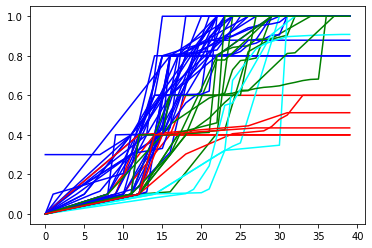

In [39]:
cmap={0:"blue",1:"green",2:"red",3:"cyan"}
for state in tseries4plot.State.unique():
    stateInfo =  tseries4plot[tseries4plot.State==state]
    plt.plot(stateInfo["index"],stateInfo.value,color = cmap[stateInfo.cluster.unique()[0]])

### Changing to Step Function

In [164]:
df_all = pd.read_csv("interventionFootprintByState.csv",index_col=0)

In [165]:
tseries = df_all.pivot(index="State",columns='dateBefore',values="interventionFootprint")
tseries[tseries.columns.min()] = tseries[tseries.columns.min()].fillna(0)
tseries[tseries.columns.max()] = tseries[tseries.columns.max()].fillna(tseries.max(axis=1))

In [166]:
tseries.head()

dateBefore,2020-02-28,2020-02-29,2020-03-01,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-28
State,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.000000
Alaska,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878737
Arizona,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
Arkansas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000
California,0.0,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [167]:
tseries.columns.astype(pd.DatetimeIndex)

Index(['2020-02-28', '2020-02-29', '2020-03-01', '2020-03-04', '2020-03-05',
       '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10',
       '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
       '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
       '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-28'],
      dtype='object', name='dateBefore')

In [168]:
tseries.columns = pd.DatetimeIndex(tseries.columns)

In [169]:
# tseries.interpolate?

In [170]:
tseries = tseries.interpolate('zero',axis=1)

In [171]:
tseries.head()

dateBefore,2020-02-28,2020-02-29,2020-03-01,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-28
State,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.820771,0.820771,0.820771,0.820771,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.878737,0.878737,0.878737,0.878737,0.878737,0.878737,0.878737,0.878737,0.878737,0.878737
Arizona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Arkansas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
California,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [172]:
tseries4plot = tseries.transpose().melt()
series = []
for state in tseries4plot.State.unique():
    series.extend(range(40))
index = pd.Series(series)
tseries4plot["index"]=index

In [173]:
tseries4plot

,State,value,index
0,Alabama,0.000000,0
1,Alabama,0.000000,1
2,Alabama,0.000000,2
3,Alabama,0.000000,3
4,Alabama,0.000000,4
...,...,...,...
1995,Wyoming,0.435137,35
1996,Wyoming,0.435137,36
1997,Wyoming,0.435137,37
1998,Wyoming,0.435137,38


In [174]:
chart = alt.Chart(tseries4plot).mark_line().encode(
        x = alt.X("index"),
        y = alt.Y("value", scale=alt.Scale(0,1)),
        facet=alt.Facet('State:O', columns=4),
    )
chart.properties(width=150,height=100,title="Step-Function Curve").interactive()

alt.Chart(...)

In [191]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = 4
clustering = AgglomerativeClustering(n_clusters=num_clusters)
clustering.fit(tseries.values)
labels = pd.Series(clustering.labels_,name="Cluster")
labels.value_counts()

0    25
1    11
3     7
2     7
Name: Cluster, dtype: int64

In [198]:
y_predict = clustering.fit_predict(tseries.values)

In [202]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
clf = NearestCentroid()
clf.fit(tseries.values, y_predict)
# print(clf.centroids_)

NearestCentroid(metric='euclidean', shrink_threshold=None)

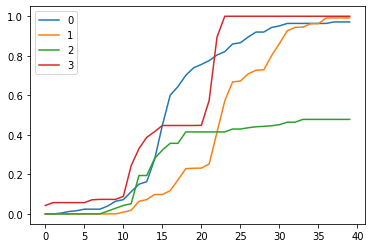

In [218]:
for idx,centroid in enumerate(clf.centroids_):
#     plt.figure()
    plt.plot(centroid,label=idx)
    plt.legend()

In [246]:
mapOriginal2InferredCentroid = {0:1,1:0,2:2,3:3}

In [247]:
for idx,centroid in enumerate(clf.centroids_):
    origClust= mapOriginal2InferredCentroid[idx]
    stateLst = list(clustResult[clustResult["cluster"]==idx].State)
    print (f"Cluster {idx}:{stateLst}")

Cluster 0:['Alabama', 'Georgia', 'Idaho', 'Maine', 'Mississippi', 'Missouri', 'New Mexico', 'Oklahoma', 'Tennessee', 'Texas', 'Virginia']
Cluster 1:['Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Minnesota', 'Montana', 'Nevada', 'New Hampshire', 'North Carolina', 'North Dakota', 'Rhode Island', 'South Carolina']
Cluster 2:['Arkansas', 'Connecticut', 'Iowa', 'Nebraska', 'South Dakota', 'Utah', 'Wyoming']
Cluster 3:['Delaware', 'Michigan', 'New York', 'Oregon', 'Washington', 'West Virginia', 'Wisconsin']


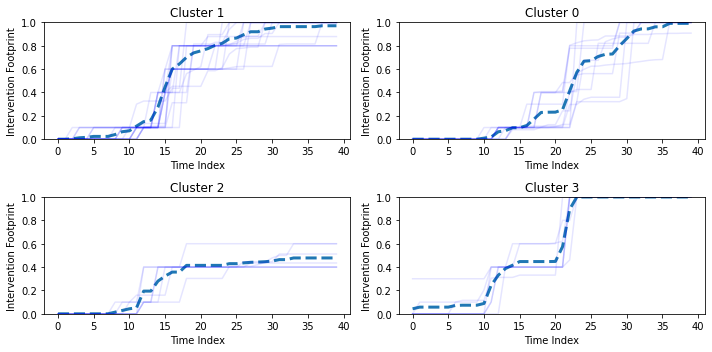

In [300]:
fig, axs = plt.subplots(2, 2,figsize=(10,5))
for idx,centroid in enumerate(clf.centroids_):
    ax = axs.flat[idx]
    origClust= mapOriginal2InferredCentroid[idx]
    stateLst = list(clustResult[clustResult["cluster"]==origClust].State)
    ax.plot(centroid,linewidth=3,linestyle='--')
    for state in stateLst:
        state_df = tseries4plot_clust[tseries4plot_clust["State"]==state]
        ax.plot(state_df["index"],state_df["value"],color="blue",alpha=0.1)
    ax.set_title(f"Cluster {origClust}")
    ax.set_ylim(0,1)
    ax.set_ylabel("Intervention Footprint")
    ax.set_xlabel("Time Index")
#     plt.title(stateLst)
plt.tight_layout()
# plt.ylabel("Intervention Footprint")

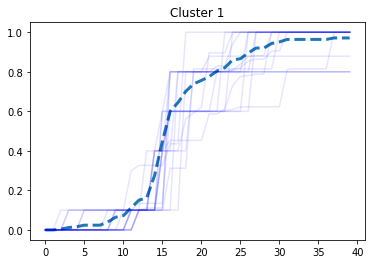

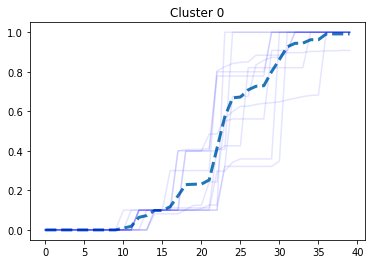

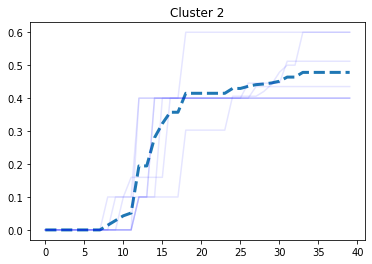

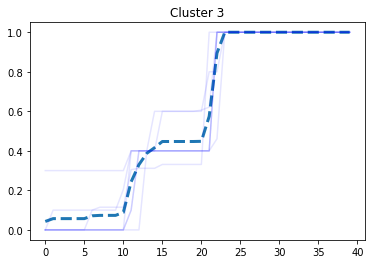

In [262]:
for idx,centroid in enumerate(clf.centroids_):
    origClust= mapOriginal2InferredCentroid[idx]
    stateLst = list(clustResult[clustResult["cluster"]==origClust].State)
    plt.figure()
    plt.plot(centroid,linewidth=3,linestyle='--')
    for state in stateLst:
        state_df = tseries4plot_clust[tseries4plot_clust["State"]==state]
        plt.plot(state_df["index"],state_df["value"],color="blue",alpha=0.1)
    plt.title(f"Cluster {origClust}")
#     plt.title(stateLst)

In [178]:
clustResult = pd.DataFrame(tseries.index)
clustResult["cluster"] = labels

tseries4plot_clust = tseries4plot.merge(clustResult)

In [180]:
chart = alt.Chart(tseries4plot_clust).mark_line().encode(
        x = alt.X("index"),
        y = alt.Y("value", scale=alt.Scale(0,1)),
        facet=alt.Facet('State:O', columns=5),
        color=alt.Color("cluster",type="nominal")
    )
chart.properties(width=150,height=100,title="Step-Function Curve").interactive()

alt.Chart(...)

### Trying out 5 clusters

In [184]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = 5
clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(tseries.values)
labels = pd.Series(clustering.labels_,name="Cluster")
labels.value_counts()

1    18
0    11
4     7
3     7
2     7
Name: Cluster, dtype: int64

In [185]:
clustResult = pd.DataFrame(tseries.index)
clustResult["cluster"] = labels

tseries4plot_clust = tseries4plot.merge(clustResult)

In [187]:
chart = alt.Chart(tseries4plot_clust).mark_line().encode(
        x = alt.X("index"),
        y = alt.Y("value", scale=alt.Scale(0,1)),
        facet=alt.Facet('State:O', columns=5),
        color=alt.Color("cluster",type="nominal")
    )
chart.properties(width=150,height=100,title="Step-Function Curve").interactive()

alt.Chart(...)

In [197]:
# # domain_pd = pd.to_datetime(['2020-03-01', '2020-04-01']).astype(int) / 10 ** 6
# chart = alt.Chart().mark_line().encode(
#         x = alt.X("dateBefore", scale=alt.Scale(domain=list(domain_pd))),
#         y = "interventionFootprint",
#     )
# chart2 = alt.Chart().mark_point().encode(
#         x = alt.X("dateBefore", scale=alt.Scale(domain=list(domain_pd))),
#         y = "interventionFootprint"
#     )
# # alt.layer(chart2).facet(data=df_all,columns='State')
# # alt.layer(chart,chart2,data=df_all).facet(column='State')

### Overlay Case count information

In [45]:
from chartlib import CovidChart, DaysSinceNumReached, days_between
days_since = 20
jhu_df = pd.read_csv('./data/jhu-data.csv')

In [ ]:
# quarantine_df = CovidChart._ingest_usa_quarantine_df(quarantine_df)

In [43]:
jhu_df[jhu_df["Country_Region"]=="United States"]

,Unnamed: 0,Country_Region,Province_State,Confirmed,Recovered,Active,Deaths,Date
0,71,United States,Alabama,7088.0,0.0,6816.0,272.0,04-30-2020
1,72,United States,Alaska,355.0,0.0,346.0,9.0,04-30-2020
2,73,United States,Arizona,7655.0,0.0,7335.0,320.0,04-30-2020
3,74,United States,Arkansas,3281.0,0.0,3220.0,61.0,04-30-2020
4,75,United States,California,50130.0,0.0,48099.0,2031.0,04-30-2020
...,...,...,...,...,...,...,...,...
20804,47,United States,"San Benito, CA",2.0,0.0,2.0,0.0,02-08-2020
20805,48,United States,"Santa Clara, CA",2.0,0.0,2.0,0.0,02-08-2020
20806,49,United States,"Seattle, WA",1.0,0.0,1.0,0.0,02-08-2020
20807,50,United States,"Tempe, AZ",1.0,0.0,1.0,0.0,02-08-2020
